# Robustness Analysis of Truncated Structured Sampling (TSS) Parameters

**Author**: Matthew Samuel  
**Date**: June 2025

## Description

This Jupyter Notebook performs a robustness analysis of **Shapley value estimation** using **Truncated Structured Sampling (TSS)** at the **Geohash level** (Scenario 1). The main goal is to evaluate how the Shapley value estimates are affected by two key parameters:

- **Truncation threshold**
- **Number of rounds (R)**

For multiple Geohash targets, different combinations of these parameters are applied to observe their influence on the stability and efficiency of the Shapley approximation.

All computations are executed in parallel using **Dask** to handle the high computational load. The event-level scenario (Scenario 2) was not feasible due to resource constraints, so this analysis is limited to the Geohash level.

The resulting plots and data insights generated by this notebook were directly used in the **Master Thesis** to support the interpretation and validation of the data valuation methodology.

In [ ]:
# imports
import pandas as pd
import numpy as np
import time
import importlib
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import config
import FrameworkGEO as fw
importlib.reload(fw)

<module 'FrameworkGEO' from '/Users/matthewsamuel1/Desktop/madrid/SHAPwithEVENTS/shapely/geohashLevel/FrameworkGEO.py'>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
input             = "input/input_data_1m.csv"                   # Path to test data 
missing_geohashes = "input/Madrid_centro_missing_ghashes.csv"   # Path to missing geohashes 
groundtruth       = "input/groundtruth_12m.csv"                 # Path to ground truth 

sel_freq = "1800"                                               # Frequency band (e.g., LTE-1800)
empty_geohashes_to_predict = 3                                  # Number of empty geohashes to predict

In [ ]:
# Dask setup and broadcast combiner/value-function

client = Client(n_workers=8, threads_per_worker=1)
config.daskClient = client
print("Dask dashboard:", client.dashboard_link)



Dask dashboard: http://127.0.0.1:64097/status


In [ ]:
# initialize combinder and scatter heavy objects
combiner = fw.KrigingDataCombination(input_path=input,missing_geohashes=missing_geohashes,sel_freq="1800")
combiner_fut = client.scatter(combiner, broadcast=True)
val_fn = fw.KrigingValueFunction(ground_truth_path=groundtruth)
val_fn_fut = client.scatter(val_fn, broadcast=True)

In [ ]:
target_geohashes = sorted(
    combiner.df1["geohash"].unique(),
    key=lambda gh: len(combiner.get_neighbors(gh)),
    reverse=False           #True = Big to small , False = Small to big
)[:empty_geohashes_to_predict]

In [ ]:
target_geohashes = ['ezjqh1dt', 'ezjqh1ep', 'ezjqh1sr']

for gh in target_geohashes:
    neighbors_df = combiner.get_neighbors(gh)
    neighbor_geohashes = neighbors_df['geohash_y'].unique()
    n_neighbors = len(neighbor_geohashes)


    total_events = combiner.df2[
        combiner.df2['geohash'].isin(neighbor_geohashes)
    ]['events'].sum()

    print(f"Geohash: {gh}")
    print(f"  Number of neighbors: {n_neighbors}")
    print(f"  Total number of events: {total_events}")
    print("-" * 40)

NameError: name 'combiner' is not defined

In [ ]:
num_iterations = 5
R_values       = [10, 25, 50, 100, 200, 300, 400, 500, 600, 700]
#R_values       = [1, 2, 5, 10, 20]


shapley_iterations = {}   # shapley_iterations[R] = array van shape (num_iterations, M)
exec_times         = []   # Average runtime per iteration for each R

for R in R_values:
    start_R = time.time()
    iteration_values = []
    for iteration in range(num_iterations):
        print(f"  R={R}, iteration {iteration+1}/{num_iterations}")
        shapley_vals = []
        for target_gh in target_geohashes:

            model     = fw.KrigingModel(combiner, target_gh, use_shapley_mode=True)
            model_fut = client.scatter(model, broadcast=True)
            framework = fw.vbdeFramework(
                iCombiner=combiner_fut,
                iModel=   model_fut,
                iValueFunction=val_fn_fut,
                i_vSbuffer=True
            )
            subindices = combiner.getSources(target_gh)
            if not subindices:
                continue
            shapley_tss, dfPerms, nExecs = framework.getTSS_parallel(
                config.daskClient,
                framework.WorkerProcess_init,
                subindices,
                R,
                0  #Truncation
            )
  
            neighbors_df = combiner.get_neighbors(target_gh).copy()
            neighbors_df['shapley_value'] = neighbors_df['subindex'].apply(
                lambda x: shapley_tss.get(x, np.nan)
            )
            shapley_vals.extend(neighbors_df['shapley_value'].tolist())
        iteration_values.append(shapley_vals)
    shapley_iterations[R] = np.vstack(iteration_values)

    # calculate runtime 
    elapsed = time.time() - start_R
    exec_times.append(elapsed / num_iterations)

In [ ]:

import matplotlib.pyplot as plt

plt.figure()
plt.plot(R_values, exec_times, marker='o')
plt.xlabel('R')
plt.ylabel('Avg. runtime per iteratie (s)')
plt.title('Average Shapley runtime per iteration vs R')
plt.grid(True)
plt.show()

In [ ]:
percent_variation = []
cv_values         = []

for R in R_values:
    arr = shapley_iterations[R]            
    means = np.nanmean(arr, axis=0)        

    diffs = np.abs(arr - np.roll(arr, shift=-1, axis=0))  

    percent_vals = diffs / np.abs(means) * 100  
    percent_variation.append(np.nanmean(percent_vals))

    stds = np.nanstd(arr, axis=0, ddof=0)
    cv = stds / abs(means)
    cv_values.append(np.nanmean(cv))

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R_values[1:], percent_variation[1:], marker='o')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Average percent variation (%)')
axs[0].set_title('Percent variation of Shapley estimates per R')
axs[0].grid(True)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter())

axs[1].plot(R_values[1:], cv_values[1:], marker='o')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Coefficient of Variation')
axs[1].set_title('Coefficient of Variation of Shapley estimates per R')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
rel_next_var = []
for i in range(len(percent_variation)-1):
    a = percent_variation[i]
    b = percent_variation[i+1]
    rel_next_var.append(np.abs(b - a)/np.abs(a)*100)

x1 = R_values[:-1]       

max_var = percent_variation[-1]
rel_to_max_var = [(np.abs(v-max_var)/np.abs(max_var)*100) 
                  for v in percent_variation]
x2 = R_values           

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(x1[1:], rel_next_var[1:], marker='o')
axs[0].set_title('% change vs next R')
axs[0].set_xlabel('Rᵢ')
axs[0].set_ylabel('Percent change (%)')
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter())
axs[0].grid(True)

axs[1].plot(x2[1:], rel_to_max_var[1:], marker='x')
axs[1].set_title(f'% change vs R={R_values[-1]}')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Percent difference (%)')
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter())
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt


rel_change = [
    (exec_times[i+1] - exec_times[i]) / exec_times[i] * 100
    for i in range(len(exec_times)-1)
]
x = R_values[:-1]

plt.figure()
plt.plot(R_values, exec_times, marker='o')
plt.xlabel('R')
plt.ylabel('Average runtime per iteration (s)')
plt.title('Runtime per R')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(x, rel_change, marker='o')
plt.xlabel('Rᵢ')
plt.ylabel('Relative change tᵢ→tᵢ₊₁ (%)')
plt.title('Relative change in runtime for different R')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

# -------------------------------------------
# Truncation analysis with fixed R
# -------------------------------------------

R_const      = 700   # constant R
trunc_values = [-0.1, -0.05, -0.01, -0.005, -0.001, -0.0005, -0.0001, 0]
trunc_results = []

for trunc in trunc_values:
    print(f"Analyzing truncation value: {trunc}")
    start = time.time()
    total_calls_saved = 0
    total_diff        = 0
    processed_targets = 0

    for target_gh in target_geohashes:
        subindices = combiner.getSources(target_gh)
        if not subindices:
            continue
        processed_targets += 1
        # Setup model & framework
        model = fw.KrigingModel(combiner, target_gh, use_shapley_mode=True)
        model_fut = client.scatter(model, broadcast=True)
       
        framework = fw.vbdeFramework(
            iCombiner=combiner_fut,
            iModel=model_fut,
            iValueFunction=val_fn_fut,
            i_vSbuffer=True
        )
        # Compute TSS Shapley using Dask parallel
        shapley_tss, dfPerms, nExecs = framework.getTSS_parallel(
            config.daskClient,
            framework.WorkerProcess_init,
            subindices,
            R_const,
            trunc
        )
        # Bereken calls saved
        total_calls_saved += len(dfPerms) * len(subindices) - nExecs
        full_coalition = tuple(sorted(subindices))
        vN             = framework.evaluateTuple(full_coalition)
        shapsum        = sum(shapley_tss.get(si, 0) for si in subindices)
        total_diff    += (shapsum - vN)

    elapsed = time.time() - start
    if processed_targets > 0:
        avg_time        = elapsed / processed_targets
        avg_calls_saved = total_calls_saved / processed_targets
        avg_diff_trunc  = total_diff / processed_targets
    else:
        avg_time = avg_calls_saved = avg_diff_trunc = 0

    trunc_results.append({
        'trunc': trunc,
        'avg_time': avg_time,
        'avg_calls_saved': avg_calls_saved,
        'avg_diff': avg_diff_trunc
    })


In [ ]:
trunc_df = pd.DataFrame(trunc_results)
trunc_df['diff_next'] = (trunc_df['avg_diff'].shift(-1) - trunc_df['avg_diff']).abs()

In [ ]:
# Plot average execution time vs. truncation
plt.figure()
plt.xscale('symlog', linthresh=1e-4)
plt.plot(trunc_df['trunc'], trunc_df['avg_time'], marker='o')
plt.xlabel('Truncation value')
plt.ylabel('Avg. execution time per truncation (s)')
plt.title(f'Execution time per truncation (R={R_const})')
plt.grid(True)
plt.show()

# Plot average calls saved vs. truncation
plt.figure()
plt.xscale('symlog', linthresh=1e-4)
plt.plot(trunc_df['trunc'], trunc_df['avg_calls_saved'], marker='o')
plt.xlabel('Truncation value')
plt.ylabel('Avg. number of calls saved')
plt.title(f'Calls saved per truncation (R={R_const})')
plt.grid(True)
plt.show()

# Plot average inefficiency vs. truncation
plt.figure()
plt.xscale('symlog', linthresh=1e-4)
plt.plot(trunc_df['trunc'], trunc_df['avg_diff'], marker='o')
plt.plot(trunc_df['trunc'], trunc_df['diff_next'], marker='x')

plt.xlabel('Truncation value')
plt.ylabel('Avg. inefficiency (Σ Shapley - v(N)) (%)')
plt.title(f'Inefficiency per truncation (R={R_const})')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend(['vs full coalition', 'i vs i+1'])
plt.show()



In [ ]:
baseline = trunc_df.set_index('trunc')['avg_calls_saved'].loc[0]
trunc_df['savings_due_to_trunc'] = trunc_df['avg_calls_saved'] - baseline

In [ ]:
# Plot
plt.figure()
plt.xscale('symlog', linthresh=1e-4)
plt.plot(trunc_df['trunc'], trunc_df['savings_due_to_trunc'], marker='o')
plt.xlabel('Truncation value')
plt.ylabel('Actual calls saved due to truncation')
plt.title(f'Actual calls saved due to truncation (R={R_const})')
plt.grid(True)
plt.tight_layout()
plt.show()

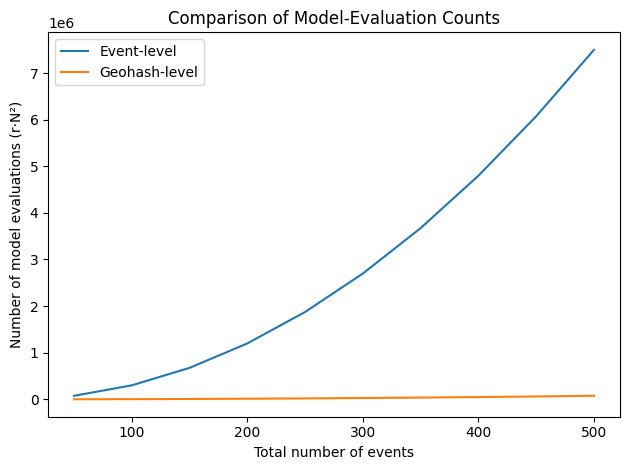

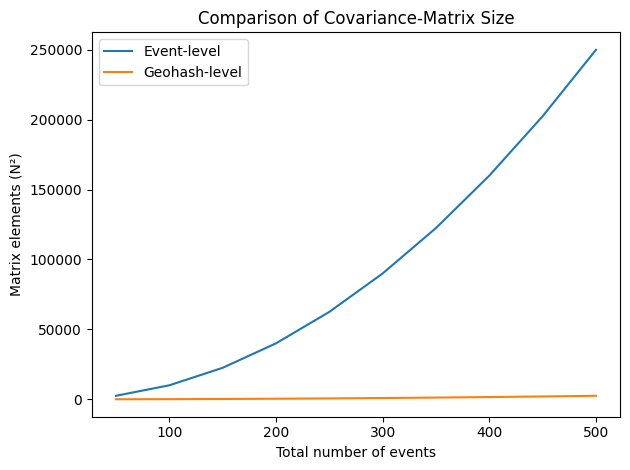

In [ ]:
# Parameters
r = 30
avg_events_per_geohash = 10
N_events = np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
N_geohash = N_events / avg_events_per_geohash

# Total number of model-evaluations: r · N²
eval_event   = r * N_events**2
eval_geohash = r * N_geohash**2

# Plot 1: Model-evaluation count comparison
plt.figure()
plt.plot(N_events, eval_event, label='Event-level')
plt.plot(N_events, eval_geohash, label='Geohash-level')
plt.xlabel('Total number of events')
plt.ylabel('Number of model evaluations (r·N²)')
plt.title('Comparison of Model-Evaluation Counts')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Covariance-matrix size comparison
mat_event   = N_events**2
mat_geohash = N_geohash**2

plt.figure()
plt.plot(N_events, mat_event, label='Event-level')
plt.plot(N_events, mat_geohash, label='Geohash-level')
plt.xlabel('Total number of events')
plt.ylabel('Matrix elements (N²)')
plt.title('Comparison of Covariance-Matrix Size')
plt.legend()
plt.tight_layout()
plt.show()